The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2023-11-25 21:29:10 INFO  [data.macd_frame:47] SELECT last(best_bid) AS data FROM UNFIUSDT_OrderBookFrame WHERE time >= '2023-11-19 03:29:10.088488' AND time <= '2023-11-26 03:29:10.088497' GROUP BY time(1m)
2023-11-25 21:29:10 DEBUG [exchange_data._database:64] SELECT last(best_bid) AS data FROM UNFIUSDT_OrderBookFrame WHERE time >= '2023-11-19 03:29:10.088488' AND time <= '2023-11-26 03:29:10.088497' GROUP BY time(1m)
2023-11-25 21:29:10 INFO  [data.macd_frame:62]                             price
time                             
2023-11-19 03:29:00+00:00   8.533
2023-11-19 03:30:00+00:00   8.529
2023-11-19 03:31:00+00:00   8.534
2023-11-19 03:32:00+00:00   8.555
2023-11-19 03:33:00+00:00   8.560
...                           ...
2023-11-26 03:25:00+00:00  14.190
2023-11-26 03:26:00+00:00  14.182
2023-11-26 03:27:00+00:00  14.182
2023-11-26 03:28:00+00:00  14.190
2023-11-26 03:29:00+00:00  14.198

[10081 rows x 1 columns]
/home/joliveros/.pyenv/versions/3.8.10/envs/exchange-data/lib

                             open    high     low   close  macd_diff  trade  \
time                                                                          
2023-11-19 03:15:00+00:00   8.533   8.533   8.533   8.533   0.000000      0   
2023-11-19 03:30:00+00:00   8.529   8.593   8.529   8.572   0.000000      0   
2023-11-19 03:45:00+00:00   8.585   8.598   8.574   8.586   0.000000      0   
2023-11-19 04:00:00+00:00   8.580   8.580   8.552   8.565   0.000000      0   
2023-11-19 04:15:00+00:00   8.556   8.556   8.511   8.516   0.000000      0   
...                           ...     ...     ...     ...        ...    ...   
2023-11-26 02:15:00+00:00  13.543  13.584  13.507  13.507   0.025223      0   
2023-11-26 02:30:00+00:00  13.488  13.988  13.449  13.809   0.035981      0   
2023-11-26 02:45:00+00:00  13.819  14.017  13.805  13.987   0.050997      0   
2023-11-26 03:00:00+00:00  13.994  14.072  13.978  14.072   0.061843      0   
2023-11-26 03:15:00+00:00  14.083  14.214  14.083  1

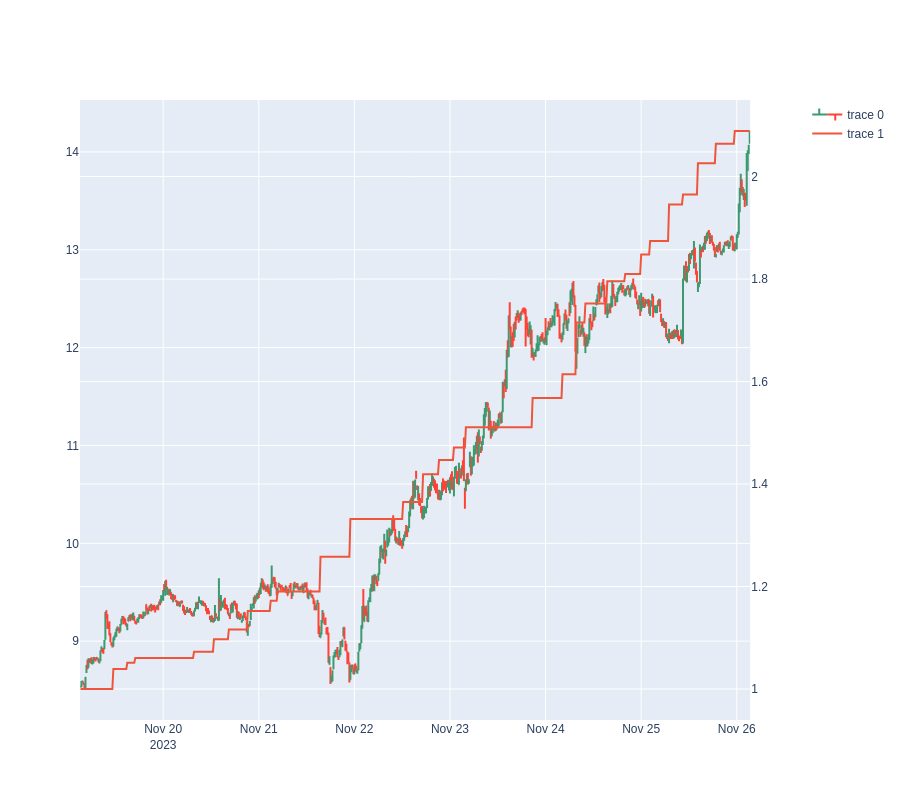

In [25]:
%load_ext autoreload
%autoreload 2

from exchange_data.data.macd_frame import MacdFrame
import pandas as pd
import numpy as np
import alog
import plotly.graph_objs as go
import plotly.express as px
import plotly as py
import plotly.offline as ofl
from plotly.offline import init_notebook_mode
import plotly.graph_objects as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)
params = {
 'database_name': 'binance_futures',
 'futures': False,
 'group_by': '1m',
 'interval': '7d',
 'offset_interval': '0h',
 'symbol': 'UNFIUSDT'
}

df = MacdFrame(**params).frame

#pd.set_option("display.max_rows", len(df) + 1)

from scipy.signal import argrelextrema
n = 6

min = argrelextrema(df['open'].to_numpy(), np.less_equal, order=n)[0]
max = argrelextrema(df['open'].to_numpy(), np.greater_equal, order=n)[0]
position = []
active_trade = False

for ix in range(0, df.shape[0]):
    if ix in max:
        active_trade=True
    if ix in min:
        active_trade=False
        
    if active_trade:
        position.append(1)
    else:
        position.append(0)

df['trade'] = position

capital = 1
df['capital'] = 0
df_len = df.shape[0]
capital_ls = []
price_in = None

for ix in range(0, df_len):
    if ix < df_len - 1:
        row = df.iloc[ix]
        next_row = df.iloc[ix + 1]
        best_ask = row['open']
        
        if row['trade'] == 1:
            if price_in == None:
                price_in = best_ask
        else:
            if price_in:
                pnl = (price_in - best_ask) / price_in
                capital = capital + (capital * pnl)
                
            price_in = None
            
    #alog.info(capital)
    capital_ls.append(capital)

df['capital'] = np.asarray(capital_ls)

print(df)

fig1 = go.Ohlc(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])

fig2 = go.Line(
    x=df.index,
    y=df['capital'],
    yaxis='y2'
)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(fig1)
fig.add_trace(fig2,secondary_y=True)
fig.update_layout(height=800)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()